<a href="https://colab.research.google.com/github/Alaqmar-Damana/Sentiment-Analysis-On-Product-Reviews/blob/main/Sentimental_Analysis_Amazon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 20.5 MB/s eta 0:00:00


In [2]:
# required libraries
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load dataset 
df = pd.read_csv(r'1429_1.csv')
df.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

In [5]:
df.shape

(34660, 21)

##Exploratory Data Analysis
**Since we are interested in sentimental analysiswe will only use `reviews.text` and `reviews.rating`**

In [6]:
data = df[["reviews.text","reviews.rating"]].sample(10000,random_state=23)
data.head()

,reviews.text,reviews.rating
21536,Bought as a Mother's Day Gift. This is great f...,4.0
20669,I can hold this next to my Kindle Paperwhite a...,5.0
30656,Love this device and went on to buy 2 as gifts...,5.0
25297,"With some technical savvy, you can quickly hav...",5.0
9016,bought for grandkids they love them. wise choi...,5.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 21536 to 29020
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.text    10000 non-null  object 
 1   reviews.rating  9993 non-null   float64
dtypes: float64(1), object(1)
memory usage: 234.4+ KB


In [8]:
# drop missing values
data.dropna(inplace=True)
data.isnull().sum()

reviews.text      0
reviews.rating    0
dtype: int64

In [9]:
# descriptive statistics
data.describe()

,reviews.rating
count,9993.000000
mean,4.591414
std,0.725462
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [10]:
data['reviews.rating'].value_counts().sort_index(ascending=False)

5.0    6891
4.0    2455
3.0     420
2.0     120
1.0     107
Name: reviews.rating, dtype: int64

In [11]:
type(data['reviews.rating'])

pandas.core.series.Series

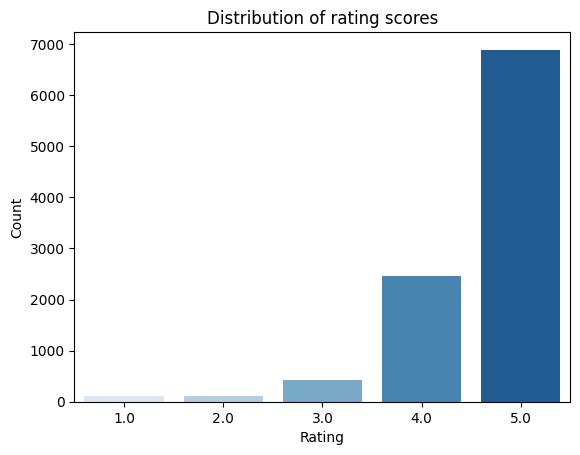

In [12]:
sns.countplot(x=data['reviews.rating'], palette='Blues')

plt.title('Distribution of rating scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [13]:
data5 = data[data['reviews.rating']==5].sample(800,random_state=43)
data4 = data[data['reviews.rating']==4].sample(200,random_state=43)
data3 = data[data['reviews.rating']==3]
data2 = data[data['reviews.rating']==2]
data1 = data[data['reviews.rating']==1]

data = pd.concat([data5,data4,data3,data3,data2,data1])

In [14]:
# distribution of rating
data['reviews.rating'].value_counts().sort_index(ascending=False)

5.0    800
4.0    200
3.0    840
2.0    120
1.0    107
Name: reviews.rating, dtype: int64

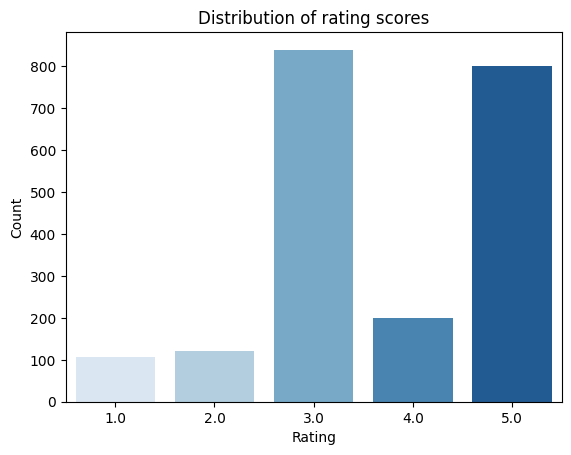

In [15]:
# distribution of rating
sns.countplot(x=data['reviews.rating'], palette='Blues')

plt.title('Distribution of rating scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [16]:
# map ratings 1, 2, 3 to 0 (NEGATIVE) and 4, 5 to 1 (POSITIVE) 
sentiment_score = {1: 0,
                   2: 0,
                   3: 0,
                   4: 1,
                   5: 1}

sentiment = {0: 'NEGATIVE',
             1: 'POSITIVE'}


# mapping
data['sentiment_score'] = data['reviews.rating'].map(sentiment_score)
data['sentiment'] = data['sentiment_score'].map(sentiment)

data.head()

,reviews.text,reviews.rating,sentiment_score,sentiment
23299,"The product was easy to set up, and is easy to...",5.0,1,POSITIVE
10583,I came in to Best Buy to get a game for my BF ...,5.0,1,POSITIVE
5018,Bought this for my toddler and teen they both ...,5.0,1,POSITIVE
30580,The product works great. If you need help usin...,5.0,1,POSITIVE
185,It may be cheap but this is a great tablet and...,5.0,1,POSITIVE


In [17]:
data['sentiment_score'].value_counts()

0    1067
1    1000
Name: sentiment_score, dtype: int64

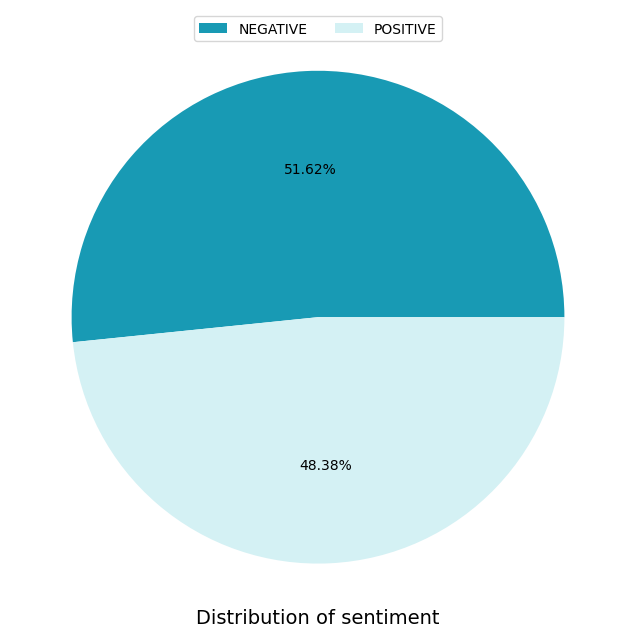

In [18]:
# distribution of sentiment
plt.figure(figsize = (8, 8))

labels = ['NEGATIVE','POSITIVE']
colors = ['#189AB4', '#D4F1F4']
plt.pie(data['sentiment'].value_counts(), autopct='%0.2f%%',colors=colors)

plt.title('Distribution of sentiment', size=14, y=-0.01)
plt.legend(labels, ncol=2, loc=9)
plt.show()

In [19]:
# get all used words 
all_words = pd.Series(' '.join(data['reviews.text']).split())

In [20]:
all_words

0            The
1        product
2            was
3           easy
4             to
          ...   
72004       lot,
72005      liked
72006         it
72007          a
72008     lot!!!
Length: 72009, dtype: object

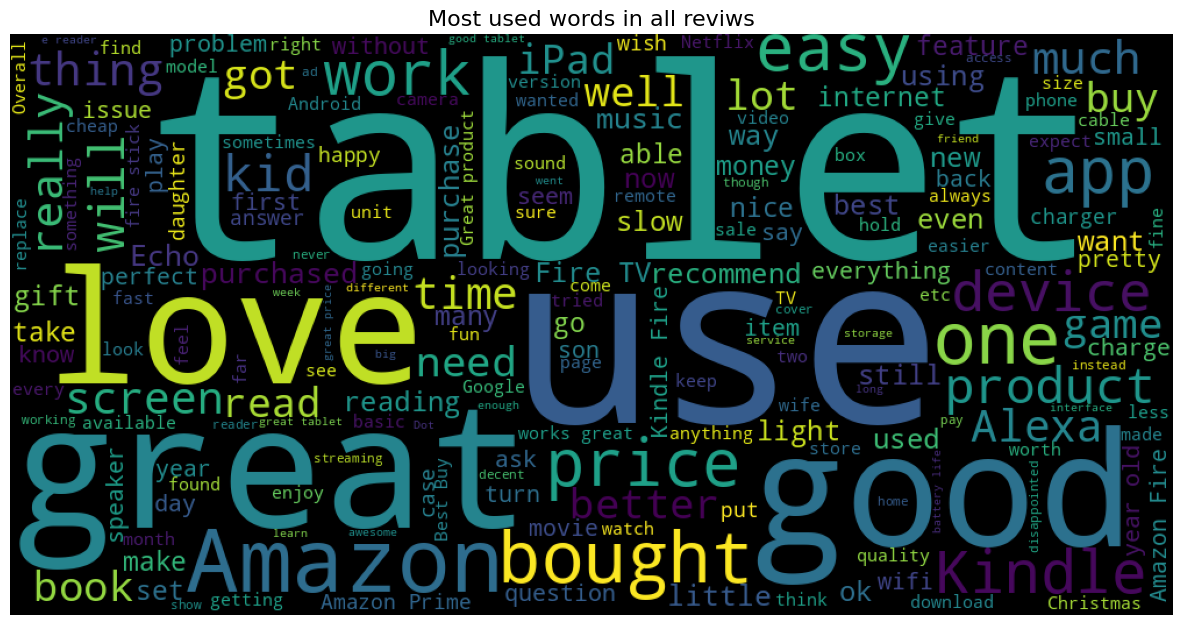

In [21]:
# plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(all_words))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in all reviws", size=16)

plt.axis("off")
plt.show()

In [22]:
# get words used positive reivews 
positiveWords = pd.Series(' '.join(data[data['sentiment']=='POSITIVE']['reviews.text']).split())

In [23]:
positiveWords

0              The
1          product
2              was
3             easy
4               to
           ...    
27950    chromcast
27951         It's
27952         okay
27953           so
27954         far.
Length: 27955, dtype: object

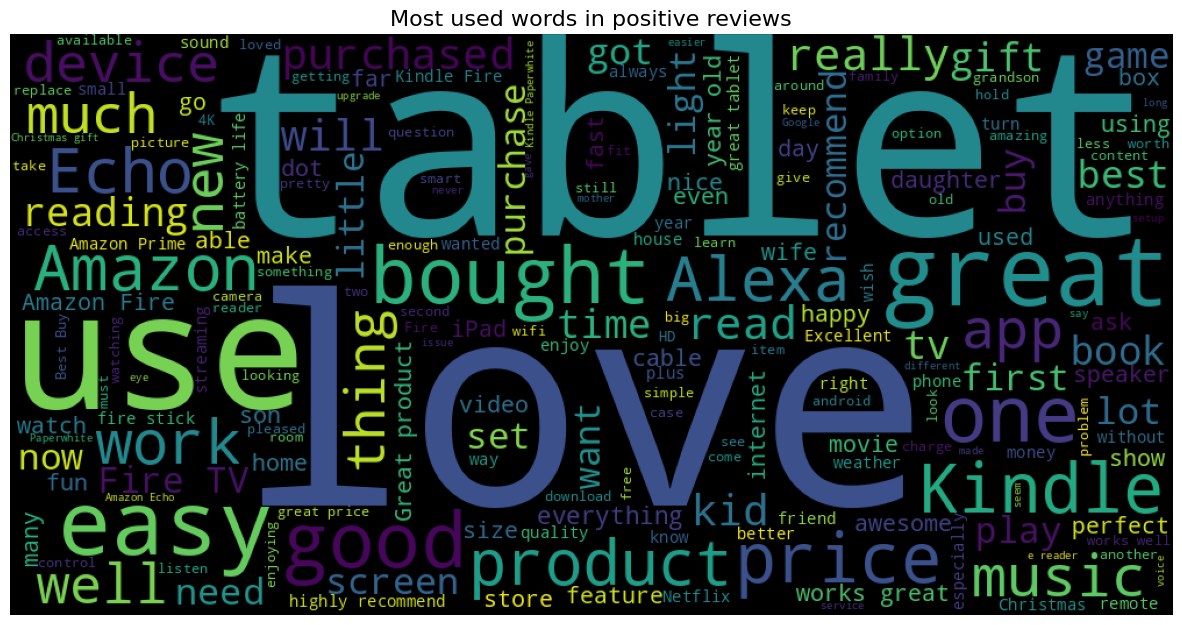

In [24]:
# plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(positiveWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in positive reviews", size=16)

plt.axis("off")
plt.show()

In [25]:
# get words used negative reivews 
negativeWords = pd.Series(' '.join(data[data['sentiment']=='NEGATIVE']['reviews.text']).split())

In [26]:
negativeWords

0           The
1        number
2           one
3        aspect
4            of
          ...  
44049      lot,
44050     liked
44051        it
44052         a
44053    lot!!!
Length: 44054, dtype: object

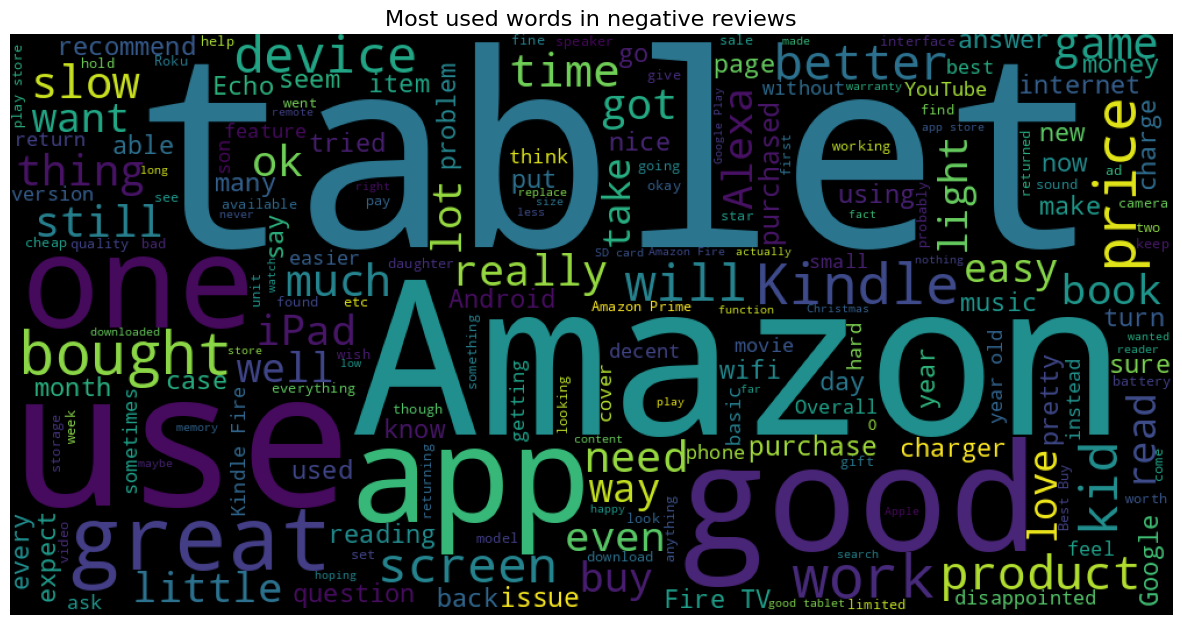

In [27]:
# plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(negativeWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in negative reviews", size=16)

plt.axis("off")
plt.show()

#Text Processing

#Cleaning the text

In [28]:
def clean_text(text:str):
    """ Return cleaned text:
            - lowercase
            - remove whitespaces
            - remove HTML tags
            - replace digit with spaces
            - replace punctuations with spaces
            - remove extra spaces and tabs
        ------
        input: text (str)    
        output: cleaned text (str)
    """
    text = str(text)
    
    text = text.lower()
    text = text.strip()
    
    text = re.sub(' \d+', ' ', text)
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    
    text = text.strip()
    
    return text

In [29]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
clean_text(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'this is a message to be cleaned it may involve some things like adjacent spaces and tabs'

#Removing Stopwords

In [30]:
def remove_stopwords(text:str):
    """ Remove stopwords from text:
        ------
        input: text (str)    
        output: cleaned text (str)
    """
    text = str(text)
    filtered_sentence = []

    # Stop word lists can be adjusted for your problem
    stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(w)
    text = " ".join(filtered_sentence)
    
    return text

In [31]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [32]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
remove_stopwords(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'message be cleaned may involve some things like adjacent spaces tabs'

#Stemming

In [33]:
def stemm_text(text:str):
    """ Stemm text:
    ------
    input: text (str)    
    output: Stemmed text (str)
    """
    text = str(text)
    # Initialize the stemmer
    snow = SnowballStemmer('english')

    stemmed_sentence = []
    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        # Stem the word/token
        stemmed_sentence.append(snow.stem(w))
    text = " ".join(stemmed_sentence)
    
    return text

In [34]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
text = remove_stopwords(text)
stemm_text(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'messag be clean may involv some thing like adjac space tab'

#Lemmatization

In [35]:
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [36]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [37]:
def lemmatize(text:str):
    """ lemmatize text:
    ------
    input: text (str)    
    output: lemmatized text (str)
    """
    text = str(text)
    
    # Initialize the lemmatizer
    wl = WordNetLemmatizer()

    lemmatized_sentence = []

    # Tokenize the sentence
    words = word_tokenize(text)
    # Get position tags
    word_pos_tags = nltk.pos_tag(words)
    # Map the position tag and lemmatize the word/token
    for idx, tag in enumerate(word_pos_tags):
        lemmatized_sentence.append(wl.lemmatize(tag[0], get_wordnet_pos(tag[1])))

    lemmatized_text = " ".join(lemmatized_sentence)
    
    return lemmatized_text

In [38]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [39]:
# test
nltk.download('wordnet')
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
text = remove_stopwords(text)
# text = stemm_text(text)
lemmatize(text)

[nltk_data] Downloading package wordnet to /root/nltk_data...


   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'message be clean may involve some thing like adjacent space tabs'

#Applying text processing functions

In [40]:
# clean text
data['text'] = data['reviews.text'].apply(clean_text)
# remove stopwords
data['text'] = data['text'].apply(remove_stopwords)
# lemmatize
data['text'] = data['text'].apply(lemmatize)

In [41]:
# check some processed reviews
import random

i = random.choice(range(len(data)))

print(f"Original review: \n{data['reviews.text'].iloc[i]}\n")
print(f"Processed review: \n{data['text'].iloc[i]}")      

Original review: 
This is an excellent device and easy to use. 5 stars if you have Amazon Prime and want to use what's included with Prime. But if you don't have Prime, any Android TV Box would be better at half the cost.

Processed review: 
excellent device easy use star if you have amazon prime want use what s include with prime but if you don t have prime any android tv box would be good at half cost


In [42]:
# export cleaned data to csv
data.to_csv('cleaned_data.csv', index=False)

In [43]:
data = pd.read_csv('cleaned_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067 entries, 0 to 2066
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviews.text     2067 non-null   object 
 1   reviews.rating   2067 non-null   float64
 2   sentiment_score  2067 non-null   int64  
 3   sentiment        2067 non-null   object 
 4   text             2067 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 80.9+ KB


In [44]:
data[data['text'].isnull()]

,reviews.text,reviews.rating,sentiment_score,sentiment,text


In [45]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067 entries, 0 to 2066
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviews.text     2067 non-null   object 
 1   reviews.rating   2067 non-null   float64
 2   sentiment_score  2067 non-null   int64  
 3   sentiment        2067 non-null   object 
 4   text             2067 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 80.9+ KB


#Feature Engineering and Feature Selection

**Create TF-IDF**

In [46]:
vectorizer = TfidfVectorizer(max_features=700)
vectorizer.fit(data['text'])
features = vectorizer.transform(data['text'])

features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
tf_idf = pd.DataFrame(features.toarray(), columns=vectorizer.get_feature_names_out())
# tf_idf.drop('50', axis=1, inplace=True)
tf_idf.head(20)

,50,99,ability,able,about,absolutely,access,account,actually,ad,...,would,wouldn,wrong,year,yet,you,young,your,youtube,yr
0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.204674,0.0,0.0,0.407804,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
6,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
7,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
8,0.0,0.0,0.000000,0.0,0.187093,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.186704,0.0,0.000000,0.0,0.0,0.000000,0.0
9,0.0,0.0,0.000000,0.0,0.000000,0.279104,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


In [48]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf, data['sentiment_score'], test_size=0.2, random_state=42)

print (f'Train set shape\t:{X_train.shape}\nTest set shape\t:{X_test.shape}')

Train set shape	:(1653, 700)
Test set shape	:(414, 700)


In [49]:
yy = pd.DataFrame(y_train)
train_data = pd.concat([X_train, yy],axis=1)
train_data.head()


,50,99,ability,able,about,absolutely,access,account,actually,ad,...,wouldn,wrong,year,yet,you,young,your,youtube,yr,sentiment_score
408,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
194,0.0,0.0,0.0,0.0,0.0,0.0,0.372758,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
2012,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.072455,0.0,0.0,0
1144,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
1785,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0


#Oversampling

In [50]:
train_data['sentiment_score'].value_counts()

0    849
1    804
Name: sentiment_score, dtype: int64

In [51]:
target_count = train_data['sentiment_score'].value_counts()
negative_class = train_data[train_data['sentiment_score'] == 0]
positive_class = train_data[train_data['sentiment_score'] == 1]

negative_over = negative_class.sample(target_count[1], replace=True)

df_train_over = pd.concat([positive_class, negative_over], axis=0)
df_train_over = shuffle(df_train_over)
df_train_over.head()

,50,99,ability,able,about,absolutely,access,account,actually,ad,...,wouldn,wrong,year,yet,you,young,your,youtube,yr,sentiment_score
568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1
133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1
1356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0
434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.156487,0.0,0.214209,0.0,0.153965,0.0,0.0,1
1015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0


In [52]:
df_train_over.dropna(inplace=True)

In [53]:
df_train_over['sentiment_score'].value_counts()

1    804
0    804
Name: sentiment_score, dtype: int64

In [54]:
X_train = df_train_over.iloc[:,:-1]
y_train = df_train_over['sentiment_score']

#MODELS

In [55]:
def modeling(Model, Xtrain = X_train, Xtest = X_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    print(classification_report(y_test, y_pred))
    print ('AUC ',roc_auc_score(y_test, y_pred))
    #cm = confusion_matrix(y_test, y_pred)
    confusion_matrix = pd.crosstab(index=y_test, columns=np.round(y_pred), rownames=['Actual'], colnames=['Predictions']).astype(int)
    plt.figure(figsize = (8,8))

    '''
    cmapGR = LinearSegmentedColormap.from_list(
        name='test', 
        colors=['red','green']
    )
    '''
    sns.heatmap(confusion_matrix, annot=True,annot_kws={"fontsize":12}, fmt='.2f', cmap='Blues').set_title('Confusion Matrix') 

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       218
           1       0.77      0.77      0.77       196

    accuracy                           0.78       414
   macro avg       0.78      0.78      0.78       414
weighted avg       0.78      0.78      0.78       414

AUC  0.7796994944766897


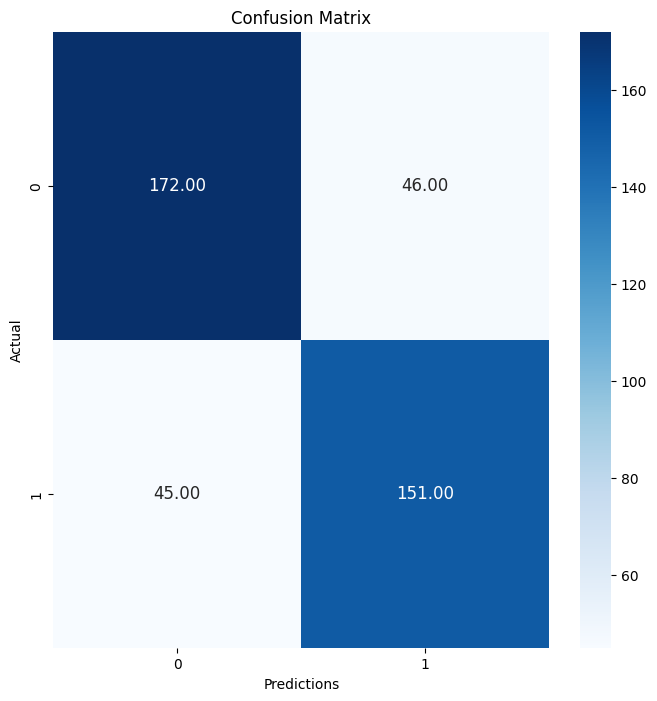

In [56]:
modeling(MultinomialNB())

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       218
           1       0.79      0.85      0.82       196

    accuracy                           0.82       414
   macro avg       0.82      0.82      0.82       414
weighted avg       0.82      0.82      0.82       414

AUC  0.8202583785807902


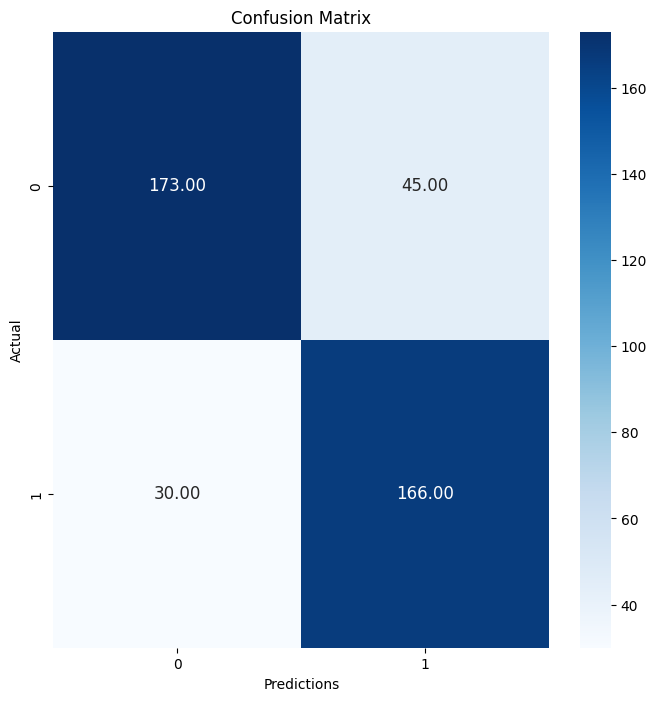

In [57]:
modeling(XGBClassifier());